In [252]:
# Random Forest Classifier on NESHAP Data

# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


# Importing the dataset
dataset = pd.read_csv('NESHAP_Data.csv')

In [253]:
# extract only columns useful for analysis
model_df = dataset[['X', 'Y', 'Facility_Name', 'GEOID10_Tract','ZCTA5CE10']]

# drop rows with missing X and Y values
model_df = model_df.dropna(subset=['X', 'Y']).reset_index(drop=True)

# check for missing values
model_df.isnull().sum()

X                  0
Y                  0
Facility_Name    100
GEOID10_Tract      0
ZCTA5CE10          0
dtype: int64

In [ ]:
# drop rows with missing Facility_Name values
model_df = model_df.dropna(subset=['Facility_Name']).reset_index(drop=True)

In [254]:
#count number of unique values in each column
model_df.nunique()

X                11489
Y                11489
Facility_Name      941
GEOID10_Tract      289
ZCTA5CE10           30
dtype: int64

In [256]:
# clean classifications function

def clean_class(df):
    # add blank Facility Type column to df
    df['Facility_Type'] = np.nan

    # where facility_name contains abandoned, ignoring case, set Facility Type to abandoned
    df.loc[df['Facility_Name'].str.contains('aban|abond',
                            na=False, case=False) & df['Facility_Type'].isnull(), 'Facility_Type'] = 'Abandoned'

    # where facility_name contains vacant, ignoring case, set Facility Type to vacant
    df.loc[df['Facility_Name'].str.contains('vacant|vac|vaacant',
                            na=False, case=False) & df['Facility_Type'].isnull(), 'Facility_Type'] = 'Vacant'

    # where facility_name contains resident or house or home, ignoring case, set Facility Type to Residential
    df.loc[df['Facility_Name'].str.contains('res|house|home|dwell|apart|project|duplex|hhf',
                            na=False, case=False) & df['Facility_Type'].isnull(), 'Facility_Type'] = 'Residential'

    # where facility_name starts with any number, set Facility Type to Residential
    df.loc[df['Facility_Name'].str.contains('1|2|3|4|5|6|7|8|9|0', 
                            na=False, case=False) & df['Facility_Type'].isnull(), 'Facility_Type'] = 'Residential'

    commercial = """comm|stor|parts|shop|office|retail|motor|islam|center|complex|school|YMCA|bar|
                    market|theatre|auto|bar|garage|car|church|corp|laund|college|indus|arts|
                    parking|psych|convent|medic|mfg|globe|news|tiki|nasar"""

    # where facility_name contains commerc, ignoring case, set Facility Type to Commerical
    df.loc[df['Facility_Name'].str.contains(commercial,
                            na=False, case=False) & df['Facility_Type'].isnull(), 'Facility_Type'] = 'Commercial'

    drop_names = """FACILITY|DEMOLITION|PROPERTY|ordered|STRUCTURE|Kevin|BUILDING|Fire Damaged Structure"""

    # where facility_name contains specific text, set Facility Type to DROP
    df.loc[df['Facility_Name'].str.contains(drop_names,
                            na=False, case = False) & df['Facility_Type'].isnull(), 'Facility_Type'] = 'DROP'

    # set remaining Facility Type to Commerical
    df.loc[df['Facility_Type'].isnull(), 
                        'Facility_Type'] = 'Commercial'

In [257]:
clean_class(model_df)

In [258]:
# drop rows with DROP Facility Type
model_df.drop(model_df[model_df['Facility_Type'] == 'DROP'].index, inplace=True)
# drop facility_name column
model_df.drop(['Facility_Name'], axis=1, inplace=True)

In [259]:
# count unique values in Facility Type column and total them
print(model_df['Facility_Type'].value_counts())
print("Total ", model_df['Facility_Type'].value_counts().sum())

Abandoned      3860
Vacant         3749
Residential    3490
Commercial      340
Name: Facility_Type, dtype: int64
Total  11439


In [260]:
# set up target and features
X = model_df.iloc[:, :-1].values
y = model_df.iloc[:, -1].values

# Splitting the dataset into the Training set and Test set, keep proportions of each Facility Type
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20144717)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 20144717)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# Evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[430   7 165 170]
 [ 12  11  24  21]
 [181   8 351 158]
 [203   8 167 372]]
              precision    recall  f1-score   support

   Abandoned       0.52      0.56      0.54       772
  Commercial       0.32      0.16      0.22        68
 Residential       0.50      0.50      0.50       698
      Vacant       0.52      0.50      0.51       750

    accuracy                           0.51      2288
   macro avg       0.46      0.43      0.44      2288
weighted avg       0.51      0.51      0.51      2288

0.5087412587412588


In [269]:
# function to tune random forest classifier using random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
def rf_tuning(X_train, y_train):
    param_dist = {'n_estimators': randint(low=10, high=1000),
                    'max_depth': randint(low=1, high=100),
                    'min_samples_split': randint(low=2, high=10),
                    'min_samples_leaf': randint(low=1, high=10),
                    'max_features': randint(low=1, high=7),
                    'bootstrap': [True, False]}

    random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1_weighted', random_state=20144717)
    random_search.fit(X_train, y_train)
    best_p = random_search.best_params_
    print(random_search.best_params_)
    print(random_search.best_score_)

In [270]:
rf_tuning(X_train, y_train)

{'bootstrap': True, 'max_depth': 63, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 842}
0.5033307189605273


c:\Users\ciano\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\ciano\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


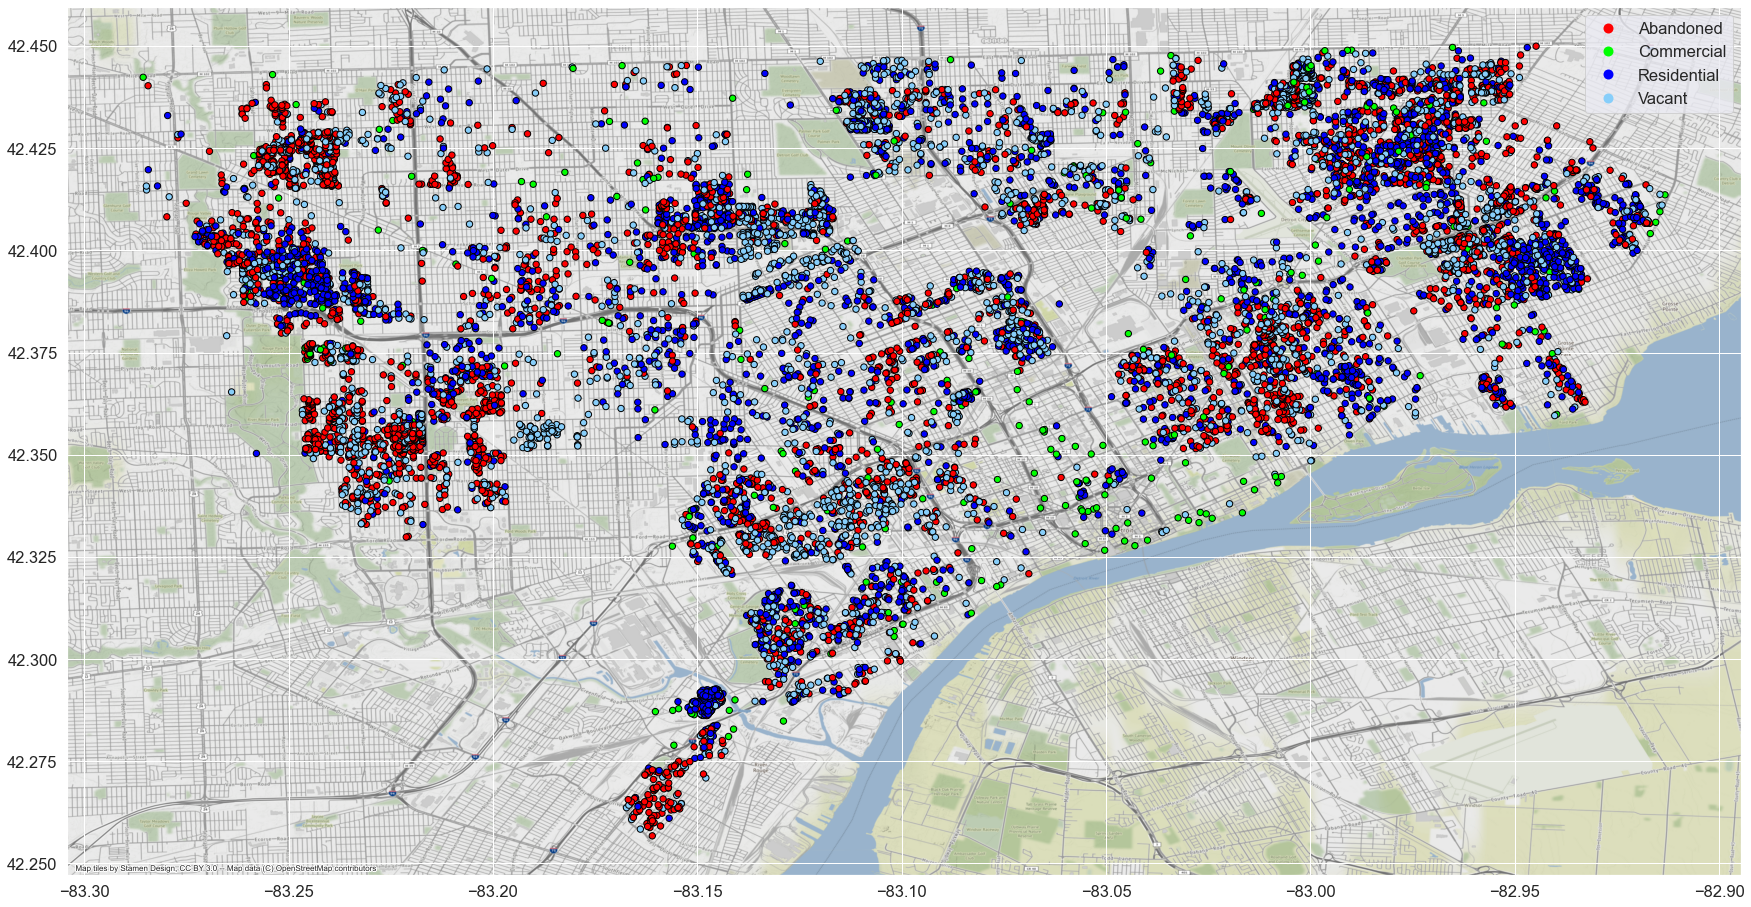

In [261]:
## Examine the data in topographical context

# transform model_df X and Y coordinates to geodataframe
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

model_df_gdf = model_df.copy()
model_df_gdf['geometry'] = model_df_gdf.apply(lambda row: Point(row['X'], row['Y']), axis=1)
model_df_gdf = model_df_gdf.drop(['X', 'Y'], axis=1)
model_df_gdf = gpd.GeoDataFrame(model_df_gdf)
model_df_gdf.crs = {'init' :'epsg:4055'}

# create plot with ctx basemap
fig, ax = plt.subplots(figsize=(30,30))
cmap = matplotlib.colors.ListedColormap(['#ff0000', '#00ff00', '#0000ff', '#87cefa'])
#cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('tab10').colors[:4])
model_df_gdf.plot(column='Facility_Type', legend=True, cmap=cmap, ax=ax, markersize = 40, edgecolors = 'black')
ctx.add_basemap(ax, crs=model_df_gdf.crs.to_string(), zoom = 14)
plt.show()

#### Little to no obvious clustering without overlay from other categories

#### Despite optimising with bagging there is little improvement in the model. Additional data may help.

In [271]:
to_import = ["CATEGORY", "LON", "LAT"]
crime_df = pd.read_csv('DPD_2009.csv', skipinitialspace=True, usecols=to_import)

print(crime_df.keys())

Index(['CATEGORY', 'LON', 'LAT'], dtype='object')


In [272]:
# count unique values in CATEGORY column and total them
print(crime_df['CATEGORY'].value_counts())
print("Total ", crime_df['CATEGORY'].value_counts().sum())

MISCELLANEOUS             174164
ASSAULT                   141608
LARCENY                   133666
BURGLARY                  109073
DAMAGE TO PROPERTY         93781
STOLEN VEHICLE             89445
AGGRAVATED ASSAULT         72577
MURDER/INFORMATION         71694
TRAFFIC                    63890
FRAUD                      40357
ROBBERY                    39292
DANGEROUS DRUGS            28081
ESCAPE                     13617
WEAPONS OFFENSES           13268
OBSTRUCTING JUDICIARY      11345
DISORDERLY CONDUCT          9252
OUIL                        8557
ARSON                       6891
SOLICITATION                3872
OBSTRUCTING THE POLICE      3268
STOLEN PROPERTY             3249
OTHER                       3135
OTHER BURGLARY              3065
HOMICIDE                    2541
FAMILY OFFENSE              1997
FORGERY                     1609
KIDNAPING                   1588
RUNAWAY                     1457
VAGRANCY (OTHER)            1138
EXTORTION                   1099
LIQUOR    

In [273]:
# drop LON or LAT with NAN values
crime_df.dropna(subset=['LON', 'LAT'], inplace=True)

In [274]:
# show distribution of LON and LAT values
print(crime_df[['LON', 'LAT']].describe())

                LON           LAT
count  1.151018e+06  1.151018e+06
mean   2.488746e+03  2.613913e+03
std    5.065024e+04  5.064388e+04
min   -1.223353e+02  1.295820e+01
25%   -8.318480e+01  4.235750e+01
50%   -8.310900e+01  4.239180e+01
75%   -8.302700e+01  4.242180e+01
max    9.999990e+05  9.999990e+05


In [275]:
# return all positive LON values
print(crime_df[crime_df['LON'] > 0]['LON'])

1          999999.0001
943        999999.0001
1308       999998.9998
3110       999999.0001
4911       999999.0001
              ...     
1149477    999998.9998
1150452    999999.0001
1150461    999998.9999
1150744    999998.9998
1150881    999998.9999
Name: LON, Length: 2991, dtype: float64


In [276]:
# drop all positive LON values as they are recording errors
crime_df.drop(crime_df[crime_df['LON'] > 0].index, inplace=True)

In [277]:
# show distribution of LON and LAT values
print(crime_df[['LON', 'LAT']].describe())

                LON           LAT
count  1.148027e+06  1.148027e+06
mean  -8.310470e+01  4.238771e+01
std    1.487827e-01  7.037807e-02
min   -1.223353e+02  2.582020e+01
25%   -8.318510e+01  4.235740e+01
50%   -8.310940e+01  4.239160e+01
75%   -8.302800e+01  4.242150e+01
max   -7.266390e+01  4.299860e+01


In [278]:
# max and min values in X and Y columns of model_df
print(model_df[['X', 'Y']].max())
print(model_df[['X', 'Y']].min())

#difference between max and min values
print(model_df[['X', 'Y']].max() - model_df[['X', 'Y']].min())


X   -82.913250
Y    42.449947
dtype: float64
X   -83.285565
Y    42.256762
dtype: float64
X    0.372314
Y    0.193185
dtype: float64


In [279]:
# create 100 square coordinate bins between min and max coordinates
bins_x = np.linspace(-82.9, -83.3, num=100)
bins_y = np.linspace(42.1, 42.5, num=100)

bins_x.sort()
bins_y.sort()

# add bins to model_df
model_df['X_bin'] = np.digitize(model_df['X'], bins_x)
model_df['Y_bin'] = np.digitize(model_df['Y'], bins_y)

In [280]:
# map crimes LON and LAT to bins
crime_df['X_bin'] = np.digitize(crime_df['LON'], bins_x)
crime_df['Y_bin'] = np.digitize(crime_df['LAT'], bins_y)

# total crimes in each combination of X and Y bins
crime_df['X_bin'].value_counts()
crime_df['Y_bin'].value_counts()

# create new df for total crimes in each combination of X and Y bins
crime_df_bins = crime_df.groupby(['X_bin', 'Y_bin']).size().reset_index(name='All_Crimes')

In [281]:
# merge crime_df_bins with model_df
model_df_bins = pd.merge(model_df, crime_df_bins, on=['X_bin', 'Y_bin'])

In [282]:
# set up target and features
X = model_df_bins.drop(['Facility_Type'], axis=1)
y = model_df_bins['Facility_Type']

# Splitting the dataset into the Training set and Test set, keep proportions of each Facility Type
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20144717)


#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 20144717)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# Evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[398   9 163 202]
 [ 18  15  14  21]
 [191   9 343 155]
 [214   8 175 353]]
              precision    recall  f1-score   support

   Abandoned       0.48      0.52      0.50       772
  Commercial       0.37      0.22      0.28        68
 Residential       0.49      0.49      0.49       698
      Vacant       0.48      0.47      0.48       750

    accuracy                           0.48      2288
   macro avg       0.46      0.42      0.44      2288
weighted avg       0.48      0.48      0.48      2288

0.4847027972027972


In [283]:
#optimised rf
rf_tuning(X_train, y_train)

{'bootstrap': True, 'max_depth': 63, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 842}
0.5064800253582393


#### Despite additional data there is no improvement in either the base RF or the optimised search
#### As such we will reduce the scope of the outcomes

In [284]:
# merge abandoned and vacant into one category, and residential and commerical into another category
model_df_bins['Facility_Type'] = model_df_bins['Facility_Type'].replace(['Abandoned', 'Vacant'], 'Abandoned/Vacant')
model_df_bins['Facility_Type'] = model_df_bins['Facility_Type'].replace(['Residential', 'Commercial'], 'Occupied')

In [285]:
# count occurrences of each category
print(model_df_bins['Facility_Type'].value_counts())
print("Total ", model_df_bins['Facility_Type'].value_counts().sum())

Abandoned/Vacant    7609
Occupied            3830
Name: Facility_Type, dtype: int64
Total  11439


In [306]:
# set up target and features
X_bin = model_df_bins.drop(['Facility_Type'], axis=1)
y_bin = model_df_bins['Facility_Type']

# Splitting the dataset into the Training set and Test set, keep proportions of each Facility Type
from sklearn.model_selection import train_test_split
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=20144717)

#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_bin_train = sc.fit_transform(X_bin_train)
X_bin_test = sc.transform(X_bin_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 20144717)
classifier.fit(X_bin_train, y_bin_train)
predictions = classifier.predict(X_test)

# Evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n", confusion_matrix(y_bin_test, predictions))
print("Classification Report: \n", classification_report(y_bin_test, predictions))
print("Accuracy Score: ", accuracy_score(y_bin_test, predictions))

Confusion Matrix: 
 [[1074  448]
 [ 549  217]]
Classification Report: 
                   precision    recall  f1-score   support

Abandoned/Vacant       0.66      0.71      0.68      1522
        Occupied       0.33      0.28      0.30       766

        accuracy                           0.56      2288
       macro avg       0.49      0.49      0.49      2288
    weighted avg       0.55      0.56      0.56      2288

Accuracy Score:  0.5642482517482518


In [287]:
# tune random forest classifier using random search
rf_tuning(X_bin_train, y_bin_train)

# save best parameters to variable
best_p = classifier.best_params_

{'bootstrap': False, 'max_depth': 44, 'max_features': 2, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 186}
0.696817866157844


In [305]:
best_model = RandomForestClassifier(n_estimators = best_p['n_estimators'], max_depth = best_p['max_depth'], 
                min_samples_split = best_p['min_samples_split'], min_samples_leaf = best_p['min_samples_leaf'], 
                max_features = best_p['max_features'], bootstrap = best_p['bootstrap'], random_state=20144717)

best_model.fit(X_bin_train, y_bin_train)
predictions = best_model.predict(X_bin_test)

# Evaluate model performance
print("Confusion Matrix: \n", confusion_matrix(y_bin_test, predictions))
print("Classification Report: \n", classification_report(y_bin_test, predictions))
print("Accuracy Score: ", accuracy_score(y_bin_test, predictions))

Confusion Matrix: 
 [[1312  210]
 [ 432  334]]
Classification Report: 
                   precision    recall  f1-score   support

Abandoned/Vacant       0.75      0.86      0.80      1522
        Occupied       0.61      0.44      0.51       766

        accuracy                           0.72      2288
       macro avg       0.68      0.65      0.66      2288
    weighted avg       0.71      0.72      0.71      2288

Accuracy Score:  0.7194055944055944


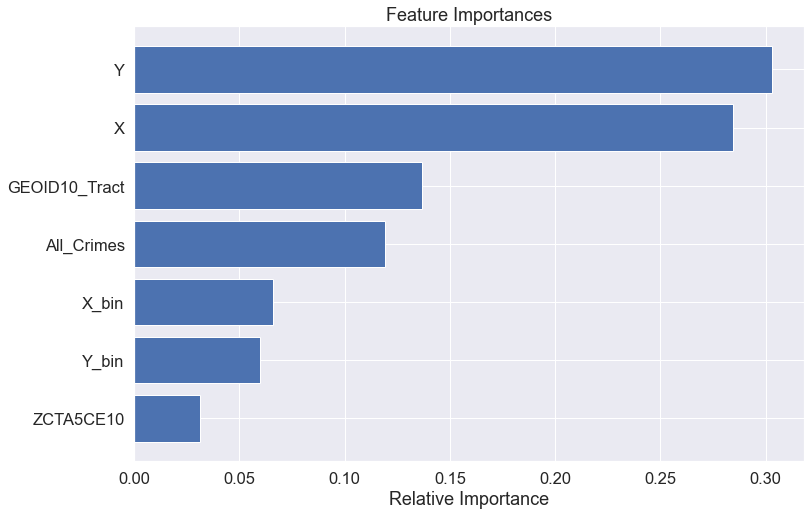

In [289]:
# plot feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# exclude Facility_Type from columns
plt.yticks(range(len(indices)), X_bin.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

In [290]:
# plot decision tree from rf
from sklearn.tree import export_graphviz
import pydot

# extract a decision tree from the forest
tree = best_model.estimators_[5]

# export the tree to a dot file
export_graphviz(tree, out_file='tree.dot', feature_names=X_bin.columns, rounded=True, precision=1)

# convert to png using system command
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# write dot file to png
graph.write_png('tree.png')

In [293]:
## create a more readable version of the tree

# create model with depth of tree limited to 4 levels
min_best_model = RandomForestClassifier(n_estimators = best_p['n_estimators'], max_depth = 4,
                min_samples_split = best_p['min_samples_split'], min_samples_leaf = best_p['min_samples_leaf'],
                max_features = best_p['max_features'], bootstrap = best_p['bootstrap'], random_state=20144717)
min_best_model.fit(X_bin_train, y_bin_train)

# extract a decision tree from the forest
small_tree = min_best_model.estimators_[5]

# export the tree to a dot file
export_graphviz(small_tree, out_file='small_tree.dot', feature_names=X_bin.columns, rounded=True, precision=1)

# convert to png using system command
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

# write dot file to png
graph.write_png('small_tree.png')